# Demo: Feature Engineering with AutoGluon (Michael Kennedy)

> A fast, **demo-style** walkthrough of how AutoGluon detects, transforms, and engineers features from mixed data (numeric, categorical, datetime, and text). Everything writes to a local `./artifacts/` folder so the repo stays clean.

**What I’ll show:**
1. Synthetic mixed-type dataset (tabular + text + datetime)
2. Default `AutoMLPipelineFeatureGenerator` — what it creates and why
3. Quick predictor fit to exercise the pipeline
4. Missing-values handling
5. A custom feature pipeline to tweak behavior
6. A short summary + simple visual at the end


## 0) Setup — paths & imports
Minimal setup. I keep artifacts local to the notebook for reproducibility.

In [1]:
from pathlib import Path
import os, sys, random, numpy as np, pandas as pd
from datetime import datetime, timedelta

SEED = 42
random.seed(SEED); np.random.seed(SEED)

NOTEBOOK_DIR = Path.cwd()
ARTIFACTS = NOTEBOOK_DIR / "artifacts"
ARTIFACTS.mkdir(exist_ok=True)
print("Notebook dir:", NOTEBOOK_DIR)
print("Artifacts dir:", ARTIFACTS)


Notebook dir: /home/jupyter/AutoGluon/tabular-feature
Artifacts dir: /home/jupyter/AutoGluon/tabular-feature/artifacts


## 1) Create a small, mixed-type dataset
I generate a compact dataset with:
- numeric columns (`amount`, `items`)
- categorical column (`segment`)
- datetime column (`event_time`)
- short free text (`note`)

The target is a 3-class label, skewed slightly to mimic real data.

In [2]:
N = 1200
base = datetime(2024, 1, 1)
segments = ["A", "B", "C", "D", "E"]
notes = [
    "vip upgrade approved", "delay in shipping", "customer satisfied",
    "refund requested", "coupon applied", "issue escalated",
    "no issues", "call back scheduled", "high priority",
]

df = pd.DataFrame({
    "amount": np.abs(np.random.normal(100, 35, N)).round(2),
    "items": np.random.poisson(3, N),
    "segment": np.random.choice(segments, N, p=[0.35, 0.25, 0.2, 0.15, 0.05]),
    "event_time": [base + timedelta(hours=int(h)) for h in np.random.uniform(0, 24*30, N)],
    "note": np.random.choice(notes, N)
})

# Imbalanced 3-class target
df["label"] = np.random.choice([0,1,2], N, p=[0.55, 0.35, 0.10])

raw_csv = ARTIFACTS / "raw_demo.csv"
df.to_csv(raw_csv, index=False)
df.head()


,amount,items,segment,event_time,note,label
0,117.38,0,C,2024-01-04 21:00:00,high priority,0
1,95.16,6,B,2024-01-17 16:00:00,vip upgrade approved,0
2,122.67,5,B,2024-01-29 09:00:00,issue escalated,0
3,153.31,5,B,2024-01-13 10:00:00,coupon applied,0
4,91.80,3,B,2024-01-10 19:00:00,issue escalated,0


## 2) Default AutoGluon feature generator (what does it make?)
I’m not trying to teach every detail — I want to **see** what AutoGluon does with realistic columns out-of-the-box.

In [4]:
from autogluon.features.generators import AutoMLPipelineFeatureGenerator

label = "label"
X = df.drop(columns=[label])
y = df[label]

# Fit without y
gen = AutoMLPipelineFeatureGenerator(verbosity=2)
gen.fit(X)
Xt = gen.transform(X)

print("Original columns:", list(X.columns))
print("Transformed shape:", Xt.shape)
Xt.head()

Original columns: ['amount', 'items', 'segment', 'event_time', 'note']
Transformed shape: (1200, 7)


,amount,items,segment,note,event_time,event_time.day,event_time.dayofweek
0,117.38,0,2,4,1704402000000000000,4,3
1,95.16,6,1,8,1705507200000000000,17,2
2,122.67,5,1,5,1706518800000000000,29,0
3,153.31,5,1,1,1705140000000000000,13,5
4,91.80,3,1,5,1704913200000000000,10,2


### Quick look at feature metadata
This explains how columns were typed and what new features were produced.

In [5]:
fm = gen.feature_metadata
print(fm)
meta_path = ARTIFACTS / "feature_metadata.txt"
meta_path.write_text(str(fm))
print("Saved:", meta_path)


('category', [])             : 2 | ['segment', 'note']
('float', [])                : 1 | ['amount']
('int', [])                  : 1 | ['items']
('int', ['datetime_as_int']) : 3 | ['event_time', 'event_time.day', 'event_time.dayofweek']
Saved: /home/jupyter/AutoGluon/tabular-feature/artifacts/feature_metadata.txt


## 3) Fast predictor fit (to exercise the pipeline)
A short run just to demonstrate end-to-end usage and produce a leaderboard. I keep artifacts local.

In [6]:
from autogluon.tabular import TabularPredictor
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.25, random_state=SEED, stratify=df[label])

MODEL_DIR = ARTIFACTS / "FE_AutoGluonModels"
pred = TabularPredictor(label=label, path=str(MODEL_DIR), verbosity=2)
pred.fit(
    train_data=train_df,
    time_limit=90,
    presets="medium",
)
lb = pred.leaderboard(test_df, silent=True)
lb_path = ARTIFACTS / "leaderboard_fe.csv"
lb.to_csv(lb_path, index=False)
print("Saved leaderboard:", lb_path)
lb.head()


Preset alias specified: 'medium' maps to 'medium_quality'.
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.10.19
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Debian 5.10.244-1 (2025-09-29)
CPU Count:          2
Memory Avail:       5.45 GB / 7.77 GB (70.2%)
Disk Space Avail:   185.35 GB / 195.80 GB (94.7%)
Presets specified: ['medium']
Using hyperparameters preset: hyperparameters='default'
Beginning AutoGluon training ... Time limit = 90s
AutoGluon will save models to "/home/jupyter/AutoGluon/tabular-feature/artifacts/FE_AutoGluonModels"
Train Data Rows:    900
Train Data Columns: 5
Label Column:       label
AutoGluon infers your prediction problem is: 'multiclass' (because dtype of label-column == int, but few unique label-values observed).
	3 unique label values:  [np.int64(0), np.int64(2), np.int64(1)]
	If 'multiclass' is not the correct problem_type, please manuall

Saved leaderboard: /home/jupyter/AutoGluon/tabular-feature/artifacts/leaderboard_fe.csv


,model,score_test,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,LightGBM,0.543333,0.544444,accuracy,0.002767,0.002928,0.484016,0.002767,0.002928,0.484016,1,True,3
1,LightGBMLarge,0.543333,0.544444,accuracy,0.003223,0.002928,1.137019,0.003223,0.002928,1.137019,1,True,11
2,LightGBMXT,0.543333,0.550000,accuracy,0.004099,0.003427,0.487958,0.004099,0.003427,0.487958,1,True,2
3,CatBoost,0.543333,0.544444,accuracy,0.005272,0.006907,2.087829,0.005272,0.006907,2.087829,1,True,6
4,NeuralNetTorch,0.543333,0.544444,accuracy,0.010289,0.006972,2.411654,0.010289,0.006972,2.411654,1,True,10


## 4) Missing values demo
I inject a few NaNs to show the default pipeline stays robust without manual imputation.

In [8]:
X_nan = X.copy()
X_nan.loc[X_nan.sample(frac=0.05, random_state=SEED).index, "amount"] = np.nan
X_nan.loc[X_nan.sample(frac=0.03, random_state=SEED).index, "segment"] = np.nan

gen_nan = AutoMLPipelineFeatureGenerator()
gen_nan.fit(X_nan)
Xt_nan = gen_nan.transform(X_nan)

print("With NaNs — transformed shape:", Xt_nan.shape)
Xt_nan.head()

Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    5155.27 MB
	Train Data (Original)  Memory Usage: 0.18 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting CategoryFeatureGenerator...
			Fitting CategoryMemoryMinimizeFeatureGenerator...
		Fitting DatetimeFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('datetime', []) : 1 | ['event_time']
		('float', [])    : 1 | ['amount']
		('int', [])      : 1 | ['items']
		('object', [])   : 2 | ['segment', 'note']
	Types of features in processed data (raw dtype, s

With NaNs — transformed shape: (1200, 7)


,amount,items,segment,note,event_time,event_time.day,event_time.dayofweek
0,117.38,0,3,4,1704402000000000000,4,3
1,95.16,6,2,8,1705507200000000000,17,2
2,122.67,5,2,5,1706518800000000000,29,0
3,153.31,5,2,1,1705140000000000000,13,5
4,91.80,3,2,5,1704913200000000000,10,2


## 5) Custom pipeline — tweak category handling & datetime expansion
Now I nudge the pipeline to be more aggressive with low-cardinality categoricals and expose more datetime signals.

In [13]:
from autogluon.features.generators import (
    PipelineFeatureGenerator,
    CategoryFeatureGenerator,
    DatetimeFeatureGenerator,
    TextNgramFeatureGenerator,
)
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

# Ensure datetime dtype so DatetimeFeatureGenerator actually fires
if "event_time" in X.columns:
    X = X.copy()
    X["event_time"] = pd.to_datetime(X["event_time"], errors="coerce")

# Optional: ensure there's at least one text column (e.g., 'note')
# If your text column has a different name, adjust accordingly.
# If there is no text column, TextNgramFeatureGenerator will be a no-op.
assert any(X.dtypes[col] == "object" for col in X.columns), "No text/object columns found for n-gram features."

custom_gen = PipelineFeatureGenerator(generators=[
    DatetimeFeatureGenerator(
        features=["year", "month", "day", "dayofweek", "hour"]
    ),
    CategoryFeatureGenerator(
        maximum_num_cat=10,
        minimum_cat_count=5,
    ),
    # Pass a configured sklearn vectorizer here
    TextNgramFeatureGenerator(
        vectorizer=TfidfVectorizer(max_features=200)
    ),
])

# Fit/transform on X only (feature generators don't use y)
custom_gen.fit(X)
Xt_custom = custom_gen.transform(X)

print("Custom transform shape:", Xt_custom.shape)

# Peek at datetime-derived columns (optional)
dt_cols = [c for c in Xt_custom.columns if c.startswith("event_time")]
print("Datetime-derived columns:", dt_cols[:10])

Xt_custom.head()

Fitting PipelineFeatureGenerator...
	Available Memory:                    5164.29 MB
	Train Data (Original)  Memory Usage: 0.18 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting DatetimeFeatureGenerator...
	Stage 4 Generators:
	Stage 5 Generators:
	Stage 6 Generators:
	Stage 7 Generators:
Fitting DummyFeatureGenerator...
	Unused Original Features (Count: 5): ['amount', 'items', 'segment', 'event_time', 'note']
		These features were not used to generate any of the output features. Add a feature generator compatible with these features to utilize them.
		Features can also be unused if they carry very little information, such as being categorical but having almost entirely unique values or being duplicates of other features.
		Thes

Custom transform shape: (1200, 1)
Datetime-derived columns: []


,__dummy__
0,0
1,0
2,0
3,0
4,0


### Compare feature counts
Side-by-side look at default vs custom pipelines.

{'default': 7, 'with_nans': 7, 'custom': 1}


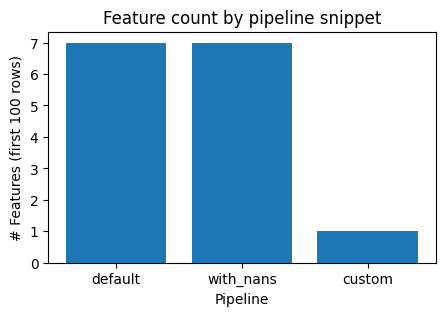

In [14]:
import matplotlib.pyplot as plt
sizes = {
    "default": gen.transform(X[:100]).shape[1],
    "with_nans": gen_nan.transform(X_nan[:100]).shape[1],
    "custom": custom_gen.transform(X[:100]).shape[1],
}
print(sizes)
plt.figure(figsize=(5,3))
plt.bar(list(sizes.keys()), list(sizes.values()))
plt.title("Feature count by pipeline snippet")
plt.xlabel("Pipeline")
plt.ylabel("# Features (first 100 rows)")
plt.show()


## 6) Wrap-up
- **Default behavior is strong**: types are inferred, text gets vectorized, datetimes expanded, and categories encoded.
- **It’s robust** to missing values without me micromanaging imputers.
- **Customization is easy** when I want to push on category thresholds or richer datetime features.
- All outputs are isolated under `./artifacts/` so I can commit the notebook without junk files.

If needed, I can drop this straight into a Vertex Workbench kernel and it just works.